In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

**This is mostly a failed attempt as the data was too large and most things did not go as planned. However, observations here are useful to create other models. **

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [6]:
def weighted_r2(y_true, y_pred, w):
    return 1 - np.sum(w * (y_true - y_pred)**2) / np.sum(w * y_true**2)

In [7]:
path = '/kaggle/input/jane-street-real-time-market-data-forecasting'

feature_cols = [f'feature_{i:02d}' for i in range(79)]
feature_cols = [c for c in feature_cols if c not in ['feature_09', 'feature_10', 'feature_11']]
target = 'responder_6'

Because of computing constraints. First, we reduce some space by converting entries to float32 from float64. This saves about half of the space. Then we also fill nans with 0. We create two folds for training and validations. 


First fold: Training = combination of partition 5,6 and testing = partition 9. Introduced lag in the testing because the actual data may not be immediate after the training data. 

Second fold: Training= combination of partition 4,5 and testing = partition 6. No lag. To ensure model does well on sequential data overall. 

In [8]:

## found this function from another notebook to reduce memory - aggressive but ok
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == object or str(col_type) == 'category':
            continue
        c_min, c_max = df[col].min(), df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        else:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    return df

def load_partition(i):
    df = pd.read_parquet(f'{path}/train.parquet/partition_id={i}/part-0.parquet')
    df[feature_cols] = df[feature_cols].fillna(0).astype('float32')
    df = reduce_mem_usage(df)
    return df



In [10]:
fold1_train = pd.concat([load_partition(i) for i in [5,6]]).reset_index(drop=True)
fold1_val = load_partition(9)

fold1_train.to_parquet('/kaggle/working/fold1_train_raw.parquet')
fold1_val.to_parquet('/kaggle/working/fold1_val_raw.parquet')


print(f"fold1: {fold1_train.shape, fold1_val.shape}")


fold1: ((11552112, 92), (6274576, 92))


In [11]:
fold1_train.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,850,0,0,2.087724,-0.276877,-2.385324,-1.086325,0.049463,3.427029,-4.671824,...,-0.295312,-0.346724,0.054874,-0.050004,0.803933,0.725200,0.141694,1.461546,0.779843,0.404129
1,850,0,1,3.752097,-0.168178,-2.161023,-0.511679,0.192425,3.162096,-4.386098,...,-0.444008,-0.086088,0.056619,-0.396622,0.396958,1.208221,-1.016843,0.789595,1.251492,-1.701416
2,850,0,2,1.225099,-0.520426,-1.718115,-0.817358,-0.270528,3.314825,-2.578923,...,-0.267447,0.636380,0.280909,1.168953,-2.395850,-1.057062,-3.009765,-2.848316,-0.974728,-5.000000
3,850,0,3,1.467042,-0.061985,-1.818735,-0.990254,0.274284,3.810929,-1.111770,...,-0.157564,2.754708,0.792327,0.403978,-0.096906,-0.263321,0.094231,-0.749164,-0.691085,-0.089415
4,850,0,5,3.144071,-0.321442,-1.964041,-0.409452,-0.343893,3.069664,-2.929145,...,-0.138634,0.151213,0.207094,0.139006,-0.440090,0.145323,-0.967585,-0.882600,0.131690,-1.548052


Skipping fold2 for now. Can't use rolling features if i have fold2 loaded at the same time because of memory constraints.

In [12]:
"""fold2_train = pd.concat([load_partition(i) for i in [4,5]]).reset_index(drop=True)
fold2_val = load_partition(6)
print(f"fold2: {fold2_train.shape} → {fold2_val.shape}")"""

'fold2_train = pd.concat([load_partition(i) for i in [4,5]]).reset_index(drop=True)\nfold2_val = load_partition(6)\nprint(f"fold2: {fold2_train.shape} → {fold2_val.shape}")'

# Feature engineering

Again, because of computing reasons. We will take top 10 correlated features in each fold and create rolling stats for top 5 features (RAM is almost full hopefully it works). Then we will models on these features.


In [13]:
def feature_engineering(train, val):
    corrs = train[feature_cols].corrwith(train[target]).abs().sort_values(ascending=False)
    top_10 = corrs.head(10).index.tolist()
    top_5 = corrs.head(5).index.tolist()
    
    # market averages on top 10
    mkt_avg = train.groupby(['date_id', 'time_id'])[top_10].mean().add_prefix('mkt_avg_')
    train = train.merge(mkt_avg, on=['date_id', 'time_id'], how='left')
    val = val.merge(mkt_avg, on=['date_id', 'time_id'], how='left')
    
    # rolling stats on top 5
    roll_feats = []
    for feat in top_5:
        for df in [train, val]:
            df[f'{feat}_roll_mean'] = df.groupby('symbol_id')[feat].transform(lambda x: x.rolling(1000, min_periods=1).mean())
            df[f'{feat}_roll_std'] = df.groupby('symbol_id')[feat].transform(lambda x: x.rolling(1000, min_periods=1).std().fillna(0))
        roll_feats += [f'{feat}_roll_mean', f'{feat}_roll_std']
    
    final_feats = top_10 + list(mkt_avg.columns) + roll_feats + ['symbol_id', 'time_id']
    
    # keep final feats + metadata + responders
    cols_to_keep = final_feats + ['date_id', 'weight', target, 'responder_3', 'responder_7', 'responder_8']
    train = train[cols_to_keep]
    val = val[cols_to_keep]
    
    return train, val, final_feats

In [14]:
train1, val1, feats1 = feature_engineering(fold1_train, fold1_val)
print(f"features: {len(feats1)}")

features: 32


In [16]:

# we can delete fold1 files to free up some memory
del fold1_train, fold1_val
gc.collect()

NameError: name 'fold1_train' is not defined

In [17]:
train1.shape

(11552112, 38)

In [18]:
X_train, y_train, w_train = train1[feats1], train1[target], train1['weight']
X_val, y_val, w_val = val1[feats1], val1[target], val1['weight']


# Fitting LGBM and XGBoost

In [19]:

lgbm = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=64, n_jobs=-1)
lgbm.fit(X_train, y_train, sample_weight=w_train,
         eval_set=[(X_val, y_val)], eval_sample_weight=[w_val],
         callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

lgbm_preds = lgbm.predict(X_val)
print(f"LGBM R²: {weighted_r2(y_val.values, lgbm_preds, w_val.values):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.565884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7944
[LightGBM] [Info] Number of data points in the train set: 11552112, number of used features: 32
[LightGBM] [Info] Start training from score -0.005323
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.632069
Early stopping, best iteration is:
[49]	valid_0's l2: 0.632016
LGBM R²: 0.003106


**We can test how the model predits the values of the target for symbol 2.**

In [20]:
sym1_mask = train1['symbol_id'] == 2
xx = train1[sym1_mask].index.values

# actual
yy_actual = train1[sym1_mask]['responder_6'].values

# predicted
yy_pred = lgbm.predict(X_train)[sym1_mask]

print(f"actual mean: {yy_actual.mean():.4f}, std: {yy_actual.std():.4f}")
print(f"pred mean:   {yy_pred.mean():.4f}, std: {yy_pred.std():.4f}")

actual mean: -0.0032, std: 0.8171
pred mean:   -0.0051, std: 0.0634


Almost no variance is not captured.

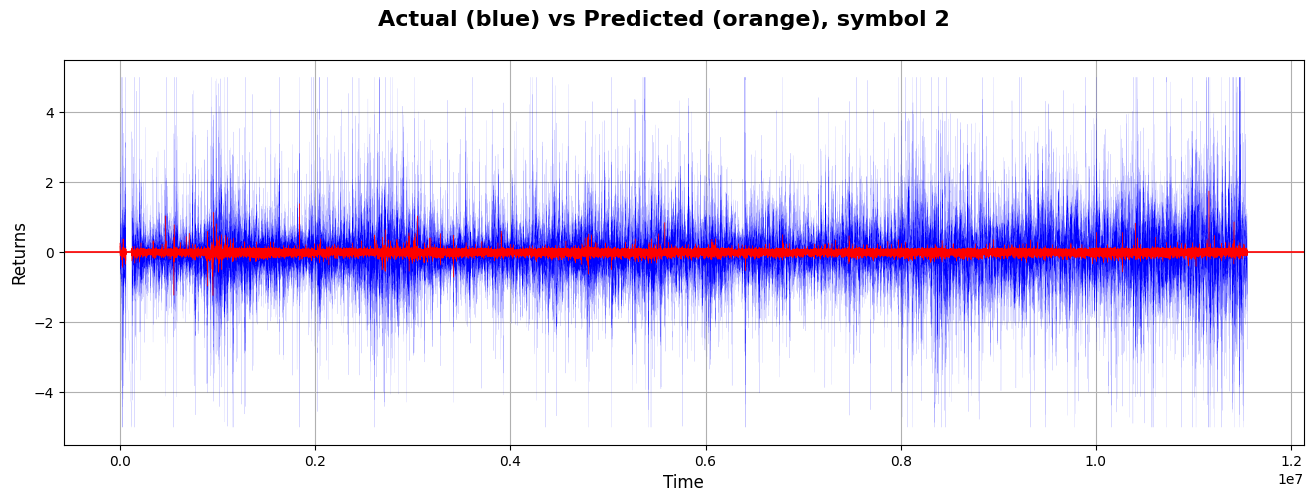

In [21]:
plt.figure(figsize=(16, 5))
plt.plot(xx, yy_actual, color='blue', linewidth=0.05)
plt.plot(xx, yy_pred, color='red', linewidth=0.3)
plt.suptitle('Actual (blue) vs Predicted (orange), symbol 2', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(linewidth=0.8)
plt.axhline(0, color='red', linestyle='-', linewidth=1.2)
plt.show()

**Also checking how model does on symbol 7**

In [22]:
sym1_mask = train1['symbol_id'] == 7
xx = train1[sym1_mask].index.values

# actual
yy_actual = train1[sym1_mask]['responder_6'].values

# predicted
yy_pred = lgbm.predict(X_train)[sym1_mask]

print(f"actual mean: {yy_actual.mean():.4f}, std: {yy_actual.std():.4f}")
print(f"pred mean:   {yy_pred.mean():.4f}, std: {yy_pred.std():.4f}")

actual mean: -0.0011, std: 0.8121
pred mean:   -0.0046, std: 0.0625


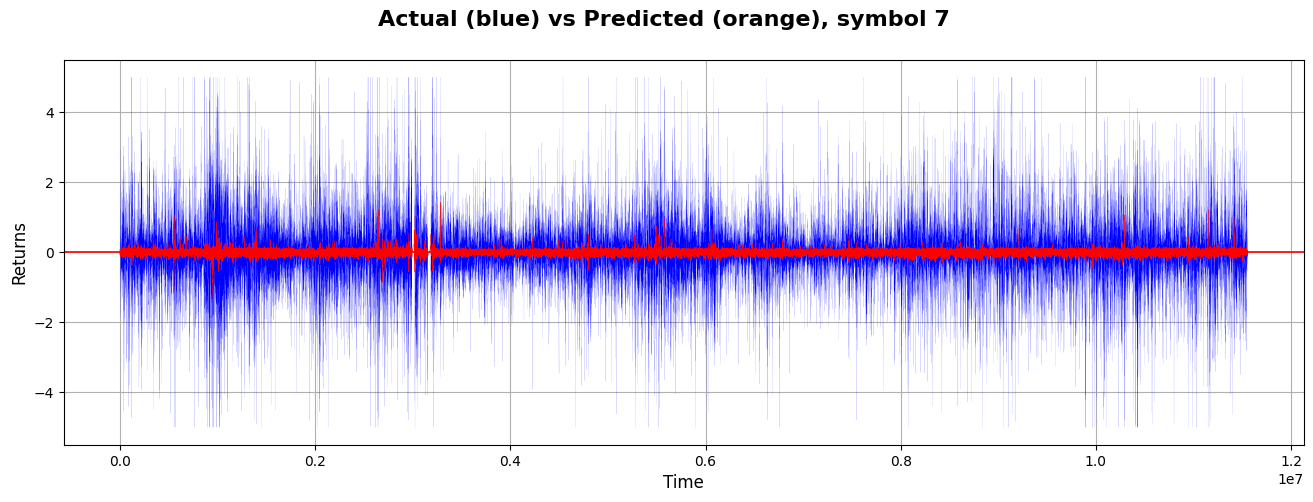

In [23]:
plt.figure(figsize=(16, 5))
plt.plot(xx, yy_actual, color='blue', linewidth=0.05)
plt.plot(xx, yy_pred, color='red', linewidth=0.3)
plt.suptitle('Actual (blue) vs Predicted (orange), symbol 7', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(linewidth=0.8)
plt.axhline(0, color='red', linestyle='-', linewidth=1.2)
plt.show()

So far, not great. Let's try XGBoost and see how it does.

In [24]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    n_jobs=-1, tree_method='hist',
    early_stopping_rounds=50
)
xgb_model.fit(X_train, y_train, sample_weight=w_train,
              eval_set=[(X_val, y_val)],
              verbose=50)

xgb_preds = xgb_model.predict(X_val)
print(f"XGBoost R²: {weighted_r2(y_val.values, xgb_preds, w_val.values):.6f}")

[0]	validation_0-rmse:0.81403
[50]	validation_0-rmse:0.81941
[56]	validation_0-rmse:0.81933
XGBoost R²: 0.001304


This is worse than LGBM. Apparently, lgbm grows trees leaf-wise instead of level-wise and does better at handling of categorical features. So not surprising.

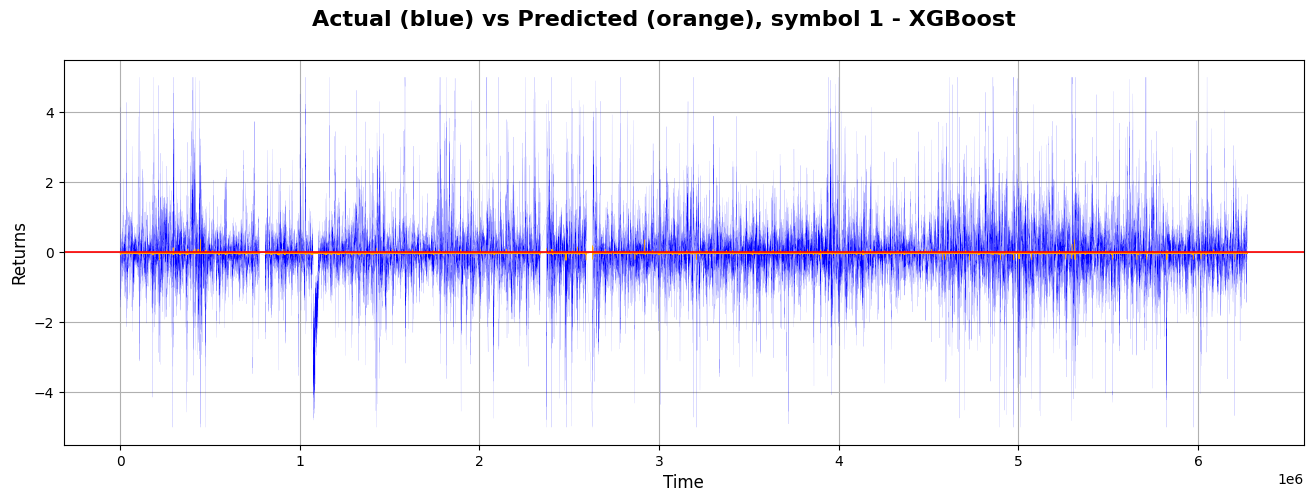

In [25]:
sym1_mask_val = val1['symbol_id'] == 1
xx_val = val1[sym1_mask_val].index.values
yy_val_actual = val1[sym1_mask_val]['responder_6'].values
yy_val_pred = xgb_preds[sym1_mask_val]

plt.figure(figsize=(16, 5))
plt.plot(xx_val, yy_val_actual, color='blue', linewidth=0.05)
plt.plot(xx_val, yy_val_pred, color='orange', linewidth=0.3)
plt.suptitle('Actual (blue) vs Predicted (orange), symbol 1 - XGBoost', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(linewidth=0.8)
plt.axhline(0, color='red', linestyle='-', linewidth=1.2)
plt.show()

Not great so far.

Summary:

LGBM R²: 0.003106 



XGBoost R² 0.001304



# Ridge regression


In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val.fillna(0))



ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train, sample_weight=w_train)

ridge_preds = ridge.predict(X_val_s)
print(f"Ridge R²: {weighted_r2(y_val.values, ridge_preds, w_val.values):.6f}")

Expected as signal is super weak.

# Second iteration.

All models have done poorly so far. 

From EDA we know responders 3,7,8 are correlated with responder_6. So we will add it in this.

Plan is to run this and see how the lgbm does first.


In [26]:
fold1_train = pd.read_parquet('/kaggle/working/fold1_train_raw.parquet')
fold1_val = pd.read_parquet('/kaggle/working/fold1_val_raw.parquet')
gc.collect()

train2 = train1.copy()
val2 = val1.copy()



In [27]:
train2[['responder_3', 'responder_7', 'responder_8']] = fold1_train[['responder_3', 'responder_7', 'responder_8']].values
val2[['responder_3', 'responder_7', 'responder_8']] = fold1_val[['responder_3', 'responder_7', 'responder_8']].values

feats_v2 = feats1 + ['responder_3', 'responder_7', 'responder_8']

In [28]:
del fold1_train, fold1_val

## LGBM

In [29]:
lgbm_v2 = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=64, n_jobs=-1)
lgbm_v2.fit(train2[feats_v2], train2[target], sample_weight=train2['weight'],
            eval_set=[(val2[feats_v2], val2[target])], eval_sample_weight=[val2['weight']],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

lgbm_v2_preds = lgbm_v2.predict(val2[feats_v2])
print(f"LGBM v2 R²: {weighted_r2(val2[target].values, lgbm_v2_preds, val2['weight'].values):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.628719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8709
[LightGBM] [Info] Number of data points in the train set: 11552112, number of used features: 35
[LightGBM] [Info] Start training from score -0.005323
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.384555
Early stopping, best iteration is:
[19]	valid_0's l2: 0.323055
LGBM v2 R²: 0.490437


There is a significant improvement. This is wrong as these responders are highly correlated, so they give the right answer. Better to fit with lags.

In [30]:
for col in ['responder_3', 'responder_7', 'responder_8']:
    train2[f'{col}_lag1'] = train2.groupby('symbol_id')[col].shift(1).fillna(0)
    val2[f'{col}_lag1'] = val2.groupby('symbol_id')[col].shift(1).fillna(0)

lag_feats = ['responder_3_lag1', 'responder_7_lag1', 'responder_8_lag1']
feats_v2 = feats1 + lag_feats

In [31]:
# drop unlagged responders
train2 = train2.drop(columns=['responder_3', 'responder_7', 'responder_8'])
val2 = val2.drop(columns=['responder_3', 'responder_7', 'responder_8'])


In [32]:
feats_v2

['feature_06',
 'feature_04',
 'feature_07',
 'feature_36',
 'feature_01',
 'feature_60',
 'feature_05',
 'feature_12',
 'feature_58',
 'feature_67',
 'mkt_avg_feature_06',
 'mkt_avg_feature_04',
 'mkt_avg_feature_07',
 'mkt_avg_feature_36',
 'mkt_avg_feature_01',
 'mkt_avg_feature_60',
 'mkt_avg_feature_05',
 'mkt_avg_feature_12',
 'mkt_avg_feature_58',
 'mkt_avg_feature_67',
 'feature_06_roll_mean',
 'feature_06_roll_std',
 'feature_04_roll_mean',
 'feature_04_roll_std',
 'feature_07_roll_mean',
 'feature_07_roll_std',
 'feature_36_roll_mean',
 'feature_36_roll_std',
 'feature_01_roll_mean',
 'feature_01_roll_std',
 'symbol_id',
 'time_id',
 'responder_3_lag1',
 'responder_7_lag1',
 'responder_8_lag1']

#### **LGBM** with lagged responders

In [ ]:
lgbm_v2 = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=64, n_jobs=-1)
lgbm_v2.fit(train2[feats_v2], train2[target], sample_weight=train2['weight'],
            eval_set=[(val2[feats_v2], val2[target])], eval_sample_weight=[val2['weight']],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

lgbm_v2_preds = lgbm_v2.predict(val2[feats_v2])
print(f"LGBM v2 R²: {weighted_r2(val2[target].values, lgbm_v2_preds, val2['weight'].values):.6f}")

This is not working. Going back to clean data.

# Third iteration

Plan now is work with residuals. Use LGBM and model residuals using XGBoost and ridge. 

In [33]:
train3 = train2.drop(columns=['responder_3_lag1', 'responder_7_lag1', 'responder_8_lag1'], errors='ignore').copy()
val3 = val2.drop(columns=['responder_3_lag1', 'responder_7_lag1', 'responder_8_lag1'], errors='ignore').copy()

In [34]:
del train2, val2

In [35]:
lgbm_v3 = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=64, n_jobs=-1)
lgbm_v3.fit(train3[feats1], train3[target], sample_weight=train3['weight'],
            eval_set=[(val3[feats1], val3[target])], eval_sample_weight=[val3['weight']],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

lgbm_v3_preds = lgbm_v3.predict(val3[feats1])
print(f"LGBM v3 R²: {weighted_r2(val3[target].values, lgbm_v3_preds, val3['weight'].values):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.564525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7944
[LightGBM] [Info] Number of data points in the train set: 11552112, number of used features: 32
[LightGBM] [Info] Start training from score -0.005323
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.632069
Early stopping, best iteration is:
[49]	valid_0's l2: 0.632016
LGBM v3 R²: 0.003106


In [36]:
resid_train = train3[target].values - lgbm_v3.predict(train3[feats1])

#### XGBoost residuals

In [37]:
xgb_resid = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    n_jobs=-1, tree_method='hist', early_stopping_rounds=50
)
xgb_resid.fit(train3[feats1], resid_train, sample_weight=train3['weight'],
              eval_set=[(val3[feats1], val3[target] - lgbm_v3_preds)],
              verbose=50)

final_preds_xgb = lgbm_v3_preds + xgb_resid.predict(val3[feats1])
print(f"LGBM + XGB residual R²: {weighted_r2(val3[target].values, final_preds_xgb, val3['weight'].values):.6f}")

[0]	validation_0-rmse:0.81287
[50]	validation_0-rmse:0.81920
[52]	validation_0-rmse:0.81967
LGBM + XGB residual R²: 0.003067


Did slightly worse than before. Let's also try the ridge. May be this only adding noise from residuals. 

#### Ridge Residuals

It needs a lot of compute.

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(train3[feats1])
X_val_s = scaler.transform(val3[feats1].fillna(0))

ridge_resid = Ridge(alpha=1.0)
ridge_resid.fit(X_train_s, resid_train, sample_weight=train3['weight'])

final_preds = lgbm_v3_preds + ridge_resid.predict(X_val_s)
print(f"LGBM + Ridge residual R²: {weighted_r2(val3[target].values, final_preds, val3['weight'].values):.6f}")

#### LGBM for residuals.

In [38]:
lgbm_resid = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=32, n_jobs=-1)
lgbm_resid.fit(train3[feats1], resid_train, sample_weight=train3['weight'],
               eval_set=[(val3[feats1], val3[target] - lgbm_v3_preds)], eval_sample_weight=[val3['weight']],
               callbacks=[lgb.early_stopping(20), lgb.log_evaluation(50)])

final_preds = lgbm_v3_preds + 0.5*lgbm_resid.predict(val3[feats1])
print(f"LGBM + LGBM residual R²: {weighted_r2(val3[target].values, final_preds, val3['weight'].values):.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.569538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7944
[LightGBM] [Info] Number of data points in the train set: 11552112, number of used features: 32
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's l2: 0.632019
LGBM + LGBM residual R²: 0.003128


This has improved R^2 by 0.003128. 


Because we are considering super lagged data. Hoping the final R^2 would be similar to this. Hope

In [40]:
for alpha in [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]:
    preds = lgbm_v3_preds + alpha * lgbm_resid.predict(val3[feats1])
    r2 = weighted_r2(val3[target].values, preds, val3['weight'].values)
    print(f"alpha={alpha}: R²={r2:.6f}")

alpha=0.1: R²=0.003114
alpha=0.2: R²=0.003121
alpha=0.3: R²=0.003125
alpha=0.5: R²=0.003128
alpha=0.7: R²=0.003123
alpha=1.0: R²=0.003101


In [43]:
import kaggle_evaluation.jane_street_inference_server
import os

def predict(test, lags):
    test = test.copy()
    test[feature_cols] = test[feature_cols].fillna(0).astype('float32')
    
    # market averages
    for col in feats1[:10]:
        test[f'mkt_avg_{col}'] = test.groupby('time_id')[col].transform('mean')
    
    X_test = test[feats1]
    
    base = lgbm_v3.predict(X_test)
    resid = lgbm_resid.predict(X_test)
    test['responder_6'] = base + 0.5*resid
    
    return test[['row_id', 'responder_6']]



In [44]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.path.exists('/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet'):
    inference_server.serve()
else:
    inference_server.run_local_gateway()

In [46]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

# Simply call serve() - it handles both test and competition modes automatically
inference_server.serve()

In [ ]:
prediction_count = 0
trade_count = 0
